In [13]:
import matplotlib.pyplot as plot
import numpy as np

import python.dataset.stat_holder as stats
import python.model_util as utils
from python.dataset.data_reader import balance_read_n
from python.dlf.losses import cross_entropy, loss1
from python.util import ModelMode

In [14]:
def draw_table(names, results):
    metric_names = list(results[0].keys())
    data = []

    for metric in metric_names:
        x = []
        for result in results:
            x.append(result[metric])
        data.append(x)

    table = plot.table(
        cellText=data,
        rowLabels=metric_names,
        colLabels=names,
        loc='center'
    )

    table.set_fontsize(16)
    table.scale(2.5, 2.5)

    plot.axis('off')
    plot.grid(False)

    plot.show()

In [15]:
_STEPS = 1000
samples = balance_read_n(_STEPS, '../data', '3476')

def calc_metrics(model):
    steps = _STEPS

    cross = []
    win_cross = []
    loss_cross = []
    y_pred = []
    y_true = []
    anlp = []

    for i in range(steps):
        if i > 0 and i % 100 == 0:
            print("Iter number %d/%d" % (i, steps))

        features, bids, targets, win = samples[i]
        survival_rate, rate_last = model.predict_on_batch([features, bids])
        cross_entropy_value = cross_entropy(targets, survival_rate)

        cross.append(cross_entropy_value)
        if win:
            anlp.append(loss1(targets, rate_last))
            win_cross.append(cross_entropy_value)
        else:
            loss_cross.append(cross_entropy_value)

        y_pred.append(survival_rate)
        y_true.append(targets)

    print("Iter number %d/%d\n" % (steps, steps))

    cross_mean = np.array(cross).mean()
    win_cross_mean = np.array(win_cross).mean()
    loss_cross_mean = np.array(loss_cross).mean()
    anlp_mean = np.array(anlp).mean()
    roc_auc_value = stats.StatHolder.calc_roc_auc_score(y_true, y_pred)

    return {'cross_entropy_win': win_cross_mean, 'cross_entropy_loss': loss_cross_mean,
            'cross_entropy': cross_mean, 'roc_auc': roc_auc_value, 'anlp': anlp_mean}

In [16]:
dlf_0503 = utils.make_model(ModelMode.DLF, 'dlf_3476_all__0.25_0.75_0.0001_20200503_1108')
dlf_0513 = utils.make_model(ModelMode.DLF, 'dlf_3476_all__0.25_0.75_0.0001_20200513_0822')
dlf_attention = utils.make_model(ModelMode.DLF_ATTENTION, 'dlf_attention_3476_all__0.25_0.75_0.0001_20200512_1719')

In [17]:
dlf_0503_result = calc_metrics(dlf_0503)
dlf_0513_result = calc_metrics(dlf_0513)
dlf_attention_result = calc_metrics(dlf_attention)

Iter number 100/1000
Iter number 200/1000
Iter number 300/1000
Iter number 400/1000
Iter number 500/1000
Iter number 600/1000
Iter number 700/1000
Iter number 800/1000
Iter number 900/1000
Iter number 1000/1000

Iter number 100/1000
Iter number 200/1000
Iter number 300/1000
Iter number 400/1000
Iter number 500/1000
Iter number 600/1000
Iter number 700/1000
Iter number 800/1000
Iter number 900/1000
Iter number 1000/1000

Iter number 100/1000
Iter number 200/1000
Iter number 300/1000
Iter number 400/1000
Iter number 500/1000
Iter number 600/1000
Iter number 700/1000
Iter number 800/1000
Iter number 900/1000
Iter number 1000/1000



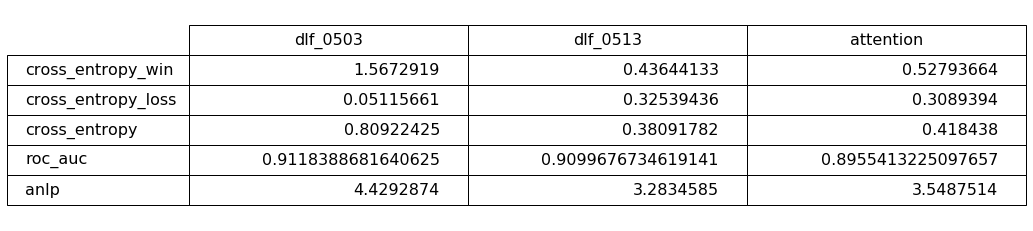

In [18]:
draw_table(['dlf_0503', 'dlf_0513', 'attention'], [dlf_0503_result, dlf_0513_result, dlf_attention_result])